In [1]:
import utils.unet_utils as ut
import torch.nn as nn
import torch.optim as optim
import torch
from torch.utils.data import DataLoader
from DataSet import ImSegDataSet
import time
!pip install -U segmentation-models-pytorch
import segmentation_models_pytorch as smp

In [2]:
def initialize_weights(m):
  if isinstance(m, nn.Conv2d):
      nn.init.xavier_normal_(m.weight.data)
  elif isinstance(m, nn.ConvTranspose2d):
      nn.init.xavier_normal_(m.weight.data)

In [3]:
#Losses 

from utils.unet_utils import train

#Use the cross entropy loss, since we have more than two classes per pixel
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def CriterionCombo(inputs,targets):

    #Get One Hot encoding of the true labels
    y_true = torch.nn.functional.one_hot(targets,24).permute(0,3,1,2).float()

    assert y_true.shape == inputs.shape
    
    BCELoss = smp.losses.SoftBCEWithLogitsLoss()
    TverskyLoss = smp.losses.TverskyLoss(mode = 'multilabel', log_loss = False)

    L1 = BCELoss(y_pred = inputs,y_true = y_true)
    L2 = TverskyLoss(y_pred = inputs,y_true = y_true)

    loss = 0.5 * L1 + 0.5 * L2

    return loss

class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        #inputs = torch.sigmoid(inputs)
        targets = torch.nn.functional.one_hot(targets,24).permute(0,3,1,2).float()       
        
        #flatten label and prediction tensors
        inputs = inputs.flatten()
        targets = targets.flatten()
        
        intersection = (inputs * targets).sum()                            
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        
        return 1 - dice

In [4]:
#crit = CriterionCombo
crit = DiceLoss()

model = ut.UNet(3, 24, [64, 128, 256, 512]).to(device)
model.apply(initialize_weights)
optimizer = optim.Adam(model.parameters(), lr = 0.0003)

#Data set and data loader for the training set
DS_training = ImSegDataSet(PathToDataSet="./data/train_set/",mode = "train")
DL_training = DataLoader(dataset=DS_training,batch_size=1,shuffle=True)

#Data set and data loader for the validation set
print("\n")
DS_validation = ImSegDataSet(PathToDataSet="./data/validation_set/",mode = "validation")
DL_validation = DataLoader(dataset=DS_validation,batch_size=5)

'''
result = train(
    model = model, 
    dataloader_training = DL_training, 
    dataLoader_validation = DL_validation,
    optimizer = optimizer, 
    criterion = crit, 
    device = device, 
    buffer_size = 5, 
    buffer_update_freq = 5,
    buffer_pick_size = 3,
    n_epochs = 5,
    patch_size = 32,
    tag = "test_run_1_2023-03-20"
    )
'''

result = train(
    model = model, 
    dataloader_training = DL_training, 
    dataLoader_validation = DL_validation,
    optimizer = optimizer, 
    criterion = crit, 
    device = device, 
    buffer_size = 2, 
    buffer_update_freq = 1,
    buffer_pick_size = 2,
    n_epochs = 5,
    patch_size = 256,
    tag = "test{}".format(time.strftime("%d-%H%M%S", time.localtime(time.time()))),
    rotation = False,
    mirroring = False,
    scaling_factor = 6,
    use_original = False
    )

#########################################################################################
INFO ABOUT THE DATA SET:
	Mode of the data set:	train
	Number of instances:	300
	Image: (C,H,W):		(3,4000,6000)
#########################################################################################


#########################################################################################
INFO ABOUT THE DATA SET:
	Mode of the data set:	validation
	Number of instances:	50
	Image: (C,H,W):		(3,4000,6000)
#########################################################################################
Epoch: 1 



  0%|          | 0/300 [00:00<?, ?it/s]

#########################################################################################
	Number of images created from each image:	15
	Shape of image batch:	torch.Size([15, 3, 256, 256])
#########################################################################################


  2%|▏         | 5/300 [00:20<19:48,  4.03s/it]


KeyboardInterrupt: 

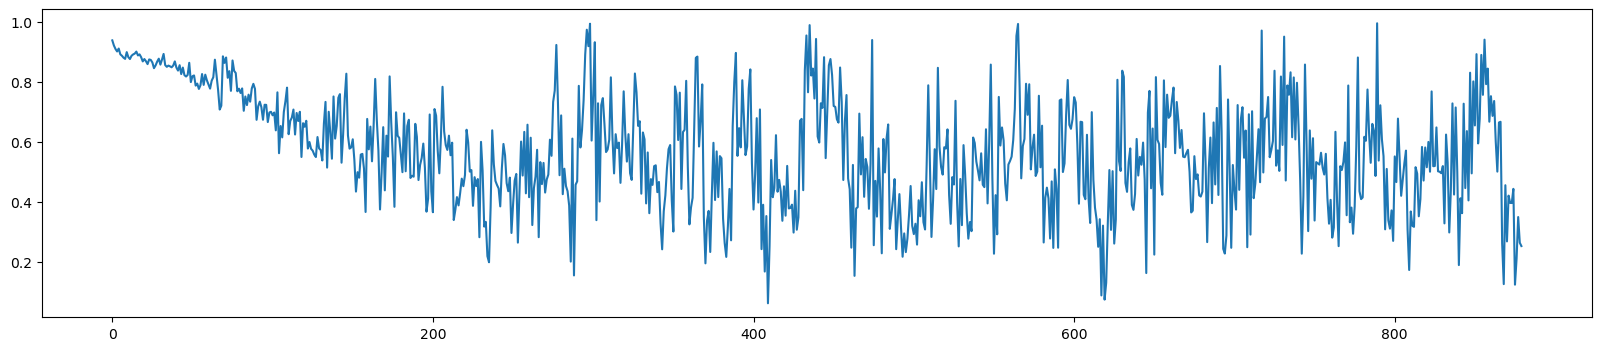

In [6]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,4)
loss = np.loadtxt("./results/test28-184443/data/training_loss.txt", skiprows=1)
plt.plot(np.arange(len(loss)), loss)

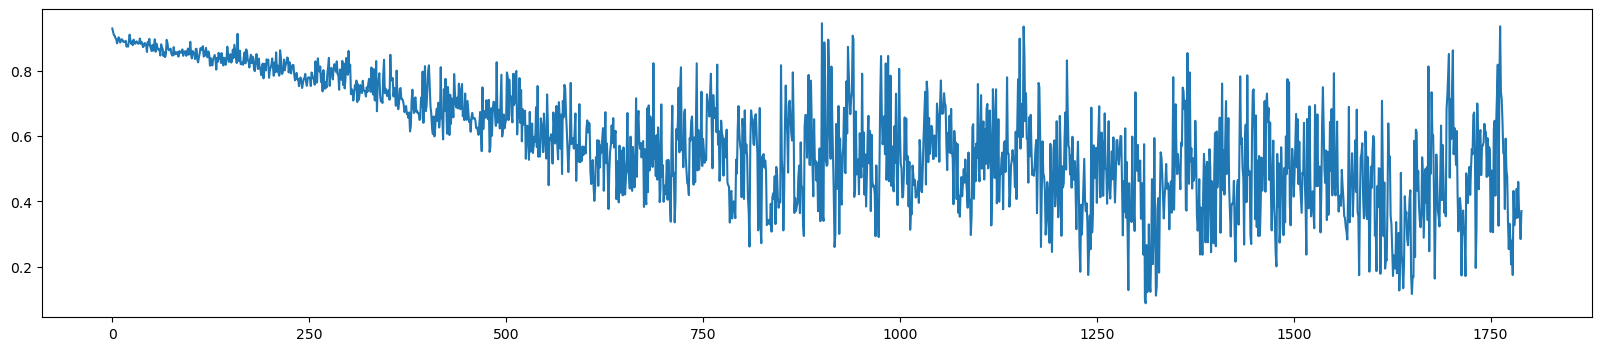

In [14]:
plt.rcParams["figure.figsize"] = (20,4)
loss = np.loadtxt("./results/test28-185510/data/training_loss.txt", skiprows=1)
plt.plot(np.arange(len(loss)), loss)

Batch size 5, 256x256, lr 0.002

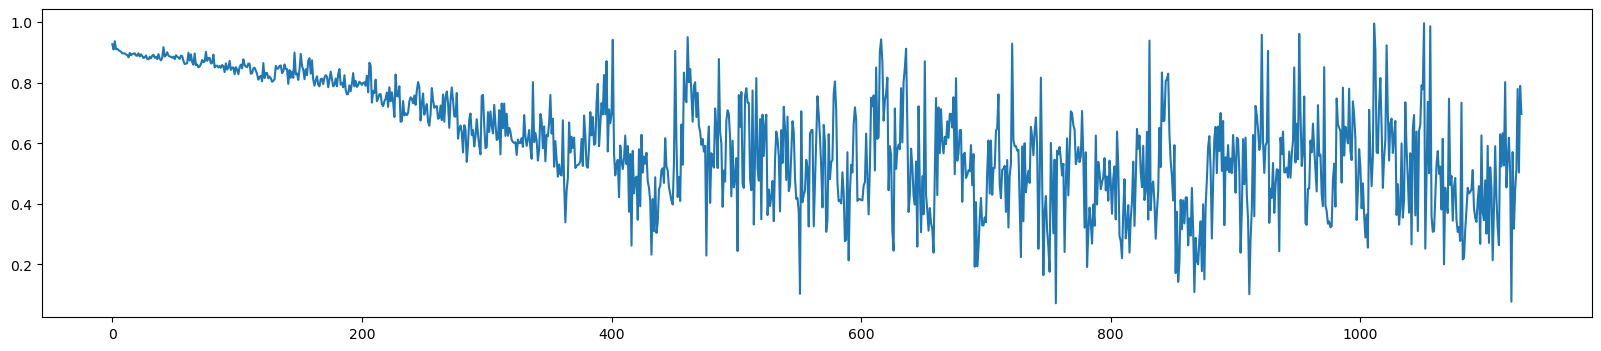

In [15]:
plt.rcParams["figure.figsize"] = (20,4)
loss = np.loadtxt("./results/test28-191733/data/training_loss.txt", skiprows=1)
plt.plot(np.arange(len(loss)), loss)

Batch size 7, 256x256, lr 0.002

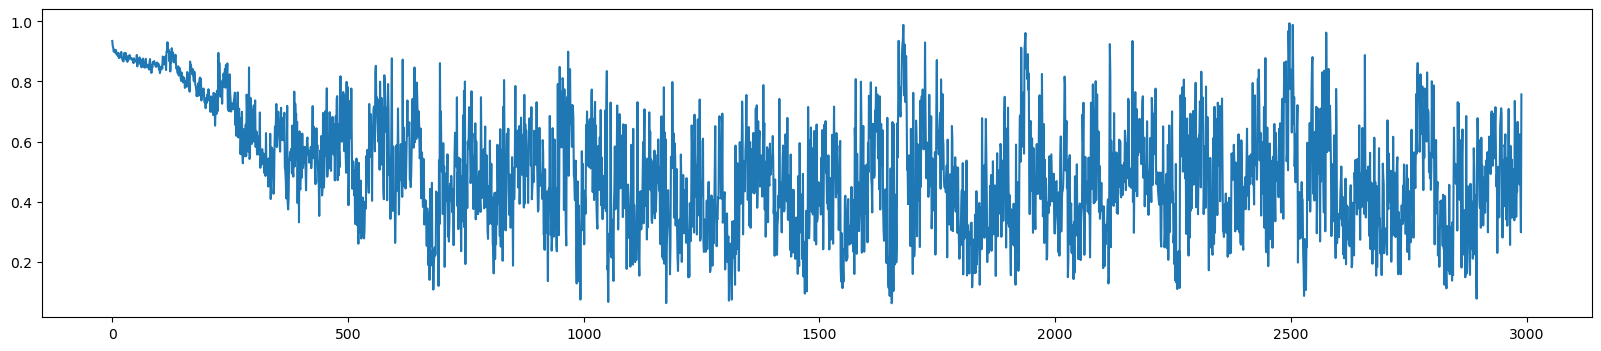

In [16]:
plt.rcParams["figure.figsize"] = (20,4)
loss = np.loadtxt("./results/test28-193412/data/training_loss.txt", skiprows=1)
plt.plot(np.arange(len(loss)), loss)

Batchsize 10, 128x128, lr 0.003

In [ ]:
plt.rcParams["figure.figsize"] = (20,4)
loss = np.loadtxt("./results/test28-193412/data/training_loss.txt", skiprows=1)
plt.plot(np.arange(len(loss)), loss)

Batchsize 15, 128x128

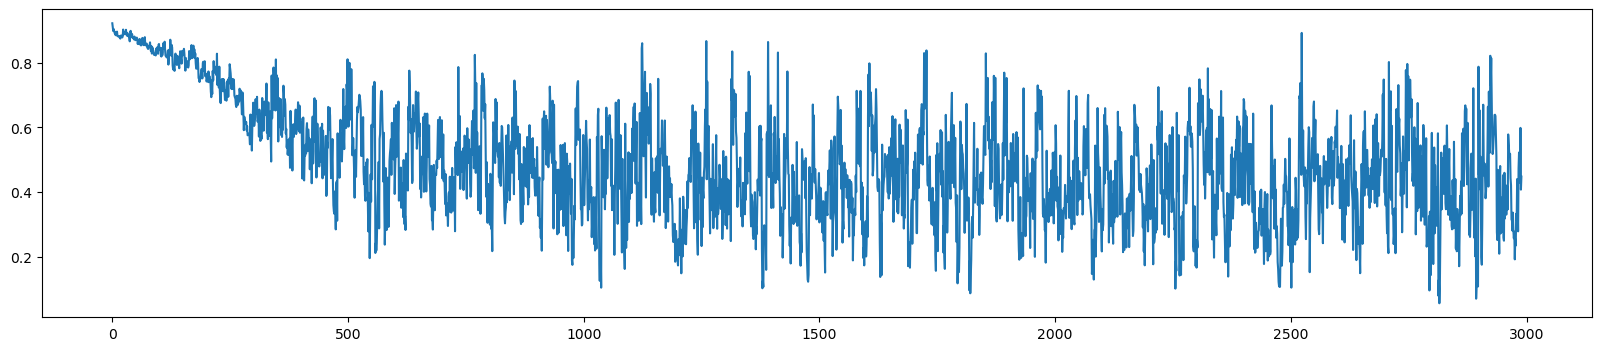

In [7]:
plt.rcParams["figure.figsize"] = (20,4)
loss = np.loadtxt("./results/test28-201311/data/training_loss.txt", skiprows=1)
plt.plot(np.arange(len(loss)), loss)